<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/tests/BoltzmanSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [1]:
# Standard install
# !pip install -q git+https://github.com/hsimonfroy/diffusion-field-level.git

# # Editable install
# !pip install -q -e git+https://github.com/hsimonfroy/diffusion-field-level.git#egg=fldiffus
# import site; site.main() # for Colab only
# # !pip install -q diffrax

import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, grad, vmap, tree, value_and_grad, jvp, debug
jconfig.update("jax_enable_x64", True)
print(jdevices())

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from fldiffus.stochinterp import StochInterp

%matplotlib inline
%load_ext autoreload
%autoreload 2

[cuda(id=0)]


2025-10-09 14:29:51.306892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1 Stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 \approx \beta_1 \approx 0$ and $\alpha_1 \approx \beta_0 \approx 1$. Then $$x_t \sim \pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) \sim x_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving (VP): $\beta_t^2 = 1-\alpha_t^2$.  
	  This implies $f_t(\bs x) = \frac{\dot \alpha_t}{\alpha_t}\bs x = \frac{g_t^2}{2}\bs x$. Typically $g_t^2 = t g_\mathrm{min}^2 + (1-t) g_\mathrm{max}^2$, then $\alpha_t = \exp\left(({g_\mathrm{min}^2(t^2-1) - g_\mathrm{max}^2(1-t)^2)/4}\right)$.
	* Variance Exploding (VE): $\alpha_t = 1$.  
	  This implies $f_t(\bs x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$. Typically $\beta_t = \beta_\mathrm{min}^t \beta_\mathrm{max}^{1-t}$, then $g_t^2 = 2\beta_t^2 \log\left(\frac{\beta_\mathrm{max}}{\beta_\mathrm{min}}\right)$.
	*  Optimal Transport (OT): $\alpha_t = t = 1 - \beta_t$.  
	  This implies $f_t(\bs x) = \frac{\bs x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$.
	* Pinned Brownian (PB): $\beta^2 = 4\beta_\mathrm{max}^2\alpha_t(1-\alpha_t)$.  
	  This implies $g_t^2 =  4\beta_\mathrm{max}^2 \dot \alpha_t$. Typically  $\alpha_t = t$, then $f_t(\bs x) = \frac{\bs x}{t}$, $g_t = 2\beta_\mathrm{max}$.

2025-10-09 14:30:25.930845: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


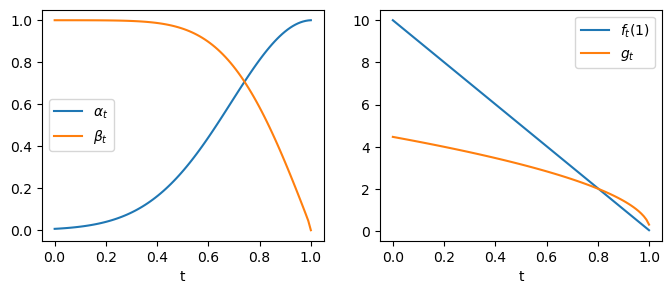

In [2]:
# @title Defining noise scheduling
stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None, snapshots=100, pid=False)

tlin = jnp.linspace(0,1,100)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(tlin, stoc.alpha(tlin), label="$\\alpha_t$")
plt.plot(tlin, stoc.beta(tlin), label="$\\beta_t$")
plt.xlabel("t"), plt.legend();

plt.subplot(122)
plt.plot(tlin, vmap(stoc.drift)(tlin, jnp.ones_like(tlin), None), label="$f_t(1)$")
plt.plot(tlin, vmap(stoc.diffusion)(tlin, jnp.ones_like(tlin), None), label="$g_t$")
plt.xlabel("t"), plt.legend();

In [3]:
n_samples = 10_000
base_samples = stoc.base.sample(n_samples, jr.key(0))
target_samples = stoc.target.sample(n_samples, jr.key(1))

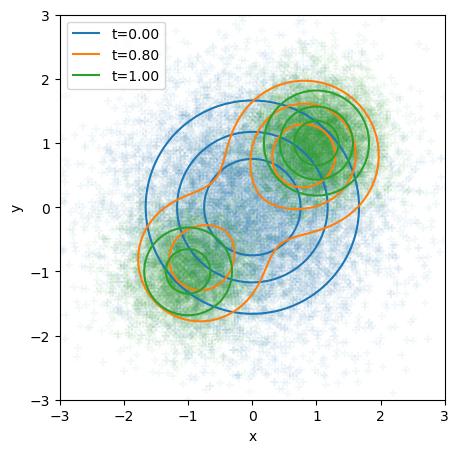

In [4]:
# @title Plot path
if stoc.dim == 1:
    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    tlin = jnp.linspace(0, 1, 7)[::-1]
    for t in tlin:
        stoc.plot_pdf(stoc.marg(t).log_prob, label=f't={t:.2f}')

    stoc.plot_pdf(tfd.Normal(loc=0., scale=1.).log_prob, ':k', label='standard');
    stoc.plot_samples(base_samples, label='base', color=f'C{len(tlin)-1}');
    stoc.plot_samples(target_samples, label='target', color='C0');
    plt.legend()

    plt.subplot(1,2,2)
    stoc.plot_margs()
    
elif stoc.dim == 2:
    plt.figure(figsize=(5,5))
    tlin = jnp.array([0., 0.8, 1.])
    handles = []
    labels = []

    for it, t in enumerate(tlin):
        quad = stoc.plot_pdf(stoc.marg(t).log_prob, levels=3, colors=f'C{it}')
        handles.append(quad.legend_elements()[0][0])
        labels.append(f't={t:.2f}')

    stoc.plot_samples(base_samples, label='base', color=f'C0');
    stoc.plot_samples(target_samples, label='target', color=f'C{len(tlin)-1}');
    plt.legend(handles, labels);

Let's try to verify that our integration time is going to be good enough, by running backward and forward ODEs and SDEs. We should obtain base distribution for the backward ones, and the target distribution for the forward ones.

In [5]:
params = None # target
# params = stoc.params
seeds = jr.split(jr.key(0), n_samples)
ts_bsde, xs_bsde = stoc.backward_sde(seeds, target_samples)
ts_fsde, xs_fsde = stoc.forward_sde(params, seeds, base_samples)
ts_bode, xs_bode, _ = stoc.backward_ode(params, target_samples)
ts_fode, xs_fode, _ = stoc.forward_ode(params, base_samples)

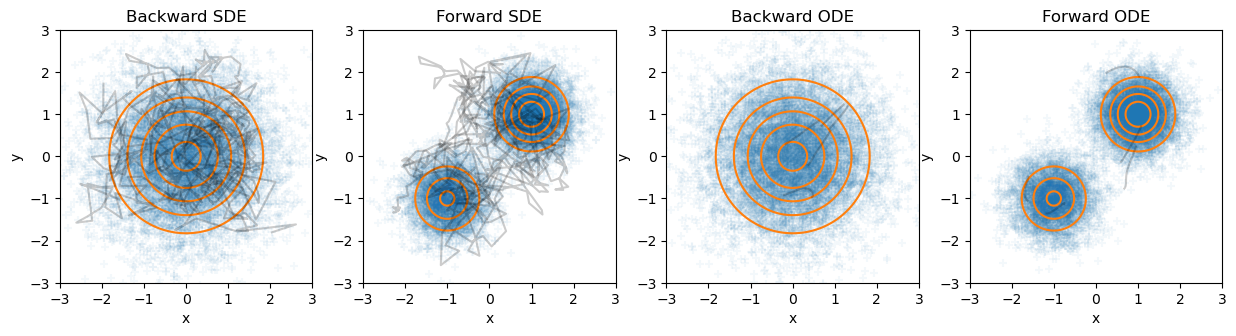

In [6]:
# @title Let's take a look at the trajectories
if stoc.dim == 1:
    n_traj = 100
    plt.figure(figsize=(14,6))
    plt.subplot(241)
    plt.plot(ts_bsde[:n_traj].T, xs_bsde[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward SDE')

    plt.subplot(242)
    plt.plot(ts_fsde[:n_traj].T, xs_fsde[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward SDE')

    plt.subplot(243)
    plt.plot(ts_bode[:n_traj].T, xs_bode[:n_traj,:,0].T, 'k', alpha=0.1);    
    plt.ylim(stoc.xlim), plt.xlim(1.,0.)
    plt.title('Backward ODE')

    plt.subplot(244)
    plt.plot(ts_fode[:n_traj].T, xs_fode[:n_traj,:,0].T, 'k', alpha=0.1);
    plt.ylim(stoc.xlim)
    plt.title('Forward ODE');

    plt.subplot(245)
    stoc.plot_pdf(stoc.base.log_prob)
    stoc.plot_samples(xs_bsde[:,-1])

    plt.subplot(246)
    stoc.plot_pdf(stoc.target.log_prob)
    stoc.plot_samples(xs_fsde[:,-1])

    plt.subplot(247)
    stoc.plot_pdf(stoc.base.log_prob)
    stoc.plot_samples(xs_bode[:,-1])

    plt.subplot(248)
    stoc.plot_pdf(stoc.target.log_prob)
    stoc.plot_samples(xs_fode[:,-1])

elif stoc.dim == 2:
    n_traj = 5
    levels = 5
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    stoc.plot_pdf(stoc.base.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_bsde[:,-1], color='C0')
    plt.plot(*xs_bsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward SDE')

    plt.subplot(142)
    stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_fsde[:,-1], color='C0')
    plt.plot(*xs_fsde[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward SDE')

    plt.subplot(143)
    stoc.plot_pdf(stoc.base.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_bode[:,-1], color='C0')
    plt.plot(*xs_bode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Backward ODE');

    plt.subplot(144)
    stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C1')
    stoc.plot_samples(xs_fode[:,-1], color='C0')
    plt.plot(*xs_fode[:n_traj].T, 'k', alpha=0.2);
    plt.title('Forward ODE');

## 2 Score network and associated proposal probability
* Eulerian formulation: the continuity equation yields $\partial_t \pp_t = -\nabla \cdot (\pp_t v_t),$ i.e.
$$\partial_t \log \pp_t = -\nabla \cdot v_t - \nabla \log \pp_t \cdot v_t.$$

* Lagrangian formulation: the continuous change of variable formula along a particle trajectory yields $\dd \log \pp_t(x(t)) = - \nabla \cdot v_t(x(t)) \ \dd t$, hence$$\log \pp_\tau(x(\tau)) = \log \pp_0(x(0)) - \int^\tau_0 \nabla \cdot v_t(x(t))\dd t = \log \pp_0(x(0)) + \int_\tau^0 \nabla \cdot v_t(x(t))\dd t$$For ODE sampling, we can simultaneously integrate forward the probability flow starting at $x(0)$, whereas for the SDE sampling, we must integrate the probability flow backward from $x(1)$ since we do not know $x(0)$.

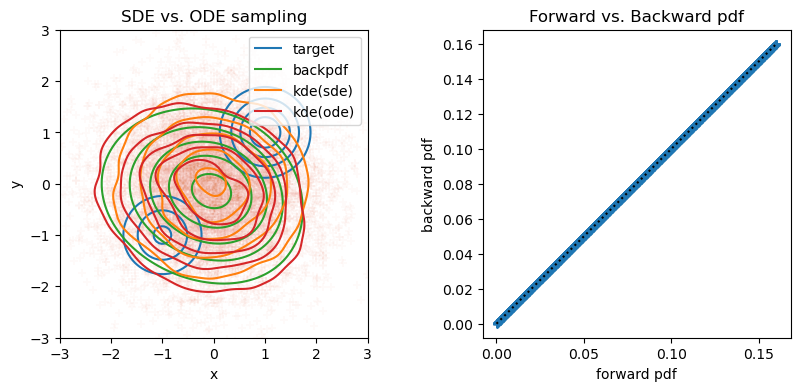

In [3]:
# @title Plot path
params = stoc.params
# params = None # target
n_samples = 10_000

def plot_results(params):
    seeds = jr.split(jr.key(0), n_samples)
    x1_sde = stoc.sample_sde(params, seeds)
    x1_ode, logp1f = stoc.sample_ode(params, seeds)
    logp1b = stoc.backward_logpdf(params, x1_ode)

    if stoc.dim == 1:
        stoc.plot_pdf(stoc.target.log_prob, 'C0', label='target')
        stoc.plot_pdf(partial(stoc._backward_logpdf, params), 'C2', label='backpdf')
        stoc.plot_kde(x1_sde, 'C1', label='kde(sde)')
        stoc.plot_kde(x1_ode, 'C3', label='kde(ode)')
        stoc.plot_samples(x1_sde, color='C1', alpha=0.1)
        stoc.plot_samples(x1_ode, color='C3', alpha=0.1)
        plt.legend()
        plt.title('SDE vs. ODE sampling')

    elif stoc.dim == 2:
        levels = 5
        handles = []
        labels = ['target', 'backpdf', 'kde(sde)', 'kde(ode)']

        quad = stoc.plot_pdf(stoc.target.log_prob, levels=levels, colors='C0')
        handles.append(quad.legend_elements()[0][0])
        quad = stoc.plot_pdf(partial(stoc._backward_logpdf, params), levels=levels, colors='C2')
        handles.append(quad.legend_elements()[0][0])
        stoc.plot_samples(x1_sde, color='C1', alpha=0.01)
        quad = stoc.plot_kde(x1_sde, levels=levels, colors='C1')
        handles.append(quad.legend_elements()[0][0])
        stoc.plot_samples(x1_sde, color='C3', alpha=0.01)
        quad = stoc.plot_kde(x1_ode, levels=levels, colors='C3')
        handles.append(quad.legend_elements()[0][0])
        plt.legend(handles, labels)
        plt.title('SDE vs. ODE sampling')
    return x1_sde, x1_ode, logp1f, logp1b

plt.figure(figsize=(10,4))
plt.subplot(121)
x1_sde, x1_ode, logp1f, logp1b = plot_results(params)

plt.subplot(122)
p1f, p2f = jnp.exp(logp1f), jnp.exp(logp1b)
plt.plot(p1f, p2f, '+', alpha=0.5);
minmax = [min(p1f.min(), p2f.min()), max(p1f.max(), p2f.max())]
plt.plot(minmax, minmax, ':k')
plt.gca().set_aspect(1.)
plt.xlabel('forward pdf'), plt.ylabel('backward pdf');
plt.title('Forward vs. Backward pdf');

## 3 Loss and training
* Most of the approches rely on estimating $v_t$ or $\nabla\log \pp_t$ via the identities:
	* $v_t(x_t) = \int v_{t \mid 1}(x_t \mid x_1)\ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{t\mid 1}(x_t \mid x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \alpha_t^{-1} \nabla \log \pp_{1}(x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$    for additive noise
* Let us define the following losses:
	* $\cL_\mathrm{FM}(\theta) := \EE_{t, x_t}[\norm{v_t^{\theta}(x_t) - v_t(x_t)}^2]$
	* $\cL_\mathrm{DFM}(\theta) := \EE_{t, x_1, x_t}[\norm{v_t^{\theta}(x_t) - v_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{SM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t}(x_t)}^2]$
	* $\cL_\mathrm{ISM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) }^2 + 2\nabla \cdot s^{\theta}_t(x_t) ]$
	* $\cL_\mathrm{DSM}(\theta) := \EE_{t, x_1, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TSM}(\theta) := \EE_{t, x_1, x_t}[\norm{s^{\theta}_t(x_t) - \alpha_t^{-1} \nabla\log \pp_{1}(x_1)}^2]$    for additive noise [*source*](http://arxiv.org/abs/2402.08667)
	* $\cL_\mathrm{EM}(\theta) := \EE_{t, x_1, x_t}[\norm{u^{\theta}_t(x_t) +\log \pp_{t}(x_t)}^2]$    [*source*](https://arxiv.org/pdf/2409.09787)
* Then we have
	* $\nabla_\theta \cL_\mathrm{FM} = \nabla_\theta \cL_\mathrm{DFM}$ and their argmin on $v^\theta$ is $v$.
	* $\nabla_\theta \cL_\mathrm{SM}= \nabla_\theta \cL_\mathrm{ISM} = \nabla_\theta \cL_\mathrm{DSM} = \nabla_\theta \cL_\mathrm{TSM}$ and their argmin on $s^\theta$ is $\nabla\log \pp$.

* The previous losses are on-policy, meaning they assume we can sample from target $x_1$. In the literature, there are two main ways of performing off-policy sampling (no target samples available) with diffusion/flow model. First define a regression objective $s_t(y_1,y_t) = \lambda_t^\mathrm{TSM} \nabla\log\pp_1(x_1) + \lambda_t^\mathrm{DSM}\nabla\log \pp_{t\mid 1}(y_t \mid y_1)$ (mixture TSM+DSM). Then one can perform Importance Sampling (IS)
	* in the loss$$\cL(\theta) := \EE_{t, y_1, y_t}[w(y_1) \norm{s^{\theta}_t(y_t) - s_t(y_1,y_t)}^2]$$
	* in the regression objective $$\cL(\theta) := \EE_{t, y_1, y_t}[\norm{s^{\theta}_t(y_t) - \EE_{z_1\mid y_t}[w(z_1)s_t(z_1,z_t)]}^2]$$
  where $y_1$ is a proposal variable for $x_1$, and $y_t := \alpha_t y_1 + \beta_t \eps$.



In [4]:
# Training loop
stoc = StochInterp(scheduling='VP', dim=2, hutch_div=None, snapshots=None, pid=False)
params = stoc.params

batch_size = 2**13 # 2**16
seed = jr.key(0)

losses = []
eval_per_esss = []
off_policy = True

# Define the optimizer
import optax
optimizer = optax.chain(
    optax.adam(learning_rate=1e-2),
    optax.contrib.reduce_on_plateau(
        factor=2**.5,
        patience=10,
        ),
    )

lr_schedule = optax.schedules.linear_onecycle_schedule(
    transition_steps=100,
    peak_value=1e-2,
    ),
optimizer = optax.adam(learning_rate=lr_schedule)

optimizer = optax.adam(learning_rate=1e-3) # 1e-3
opt_state = optimizer.init(params)

In [26]:
# @title Define the score matching loss
def loss_sm(params, t, x1, z, score1, imp_weight):
    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)

    xt = alphat * x1 + betat * z
    score_est = vmap(partial(stoc.scorenn.apply, params))(t, xt)

    ##### Denoising Score Matching #####
    ## Default time weighting
    # error_dsm = (score_est + z / betat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2101.09258
    error_dsm = (score_est * betat + z)**2
    ## Maximum likelihood time weighting, see http://arxiv.org/abs/2101.09258
    # gt = vmap(stoc.diffusion)(t, jnp.ones_like(t)[:,None], None)
    # error_dsm = ((score_est + z / betat) * gt)**2

    ##### Target Score Matching #####
    ## Default time weighting
    # error_tsm = (score_est - score1 / alphat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    error_tsm = (score_est * alphat - score1)**2

    # return (error_dsm * imp_weight).mean()
    # return (error_tsm * imp_weight).mean()
    return ((error_dsm + error_tsm) * imp_weight).mean()



# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise = jr.split(seed, 3)
    if off_policy:
        # Sample from proposal and compute importance weights
        # # Current SDE proposal
        # x1 = stoc.sample_sde(params, jr.split(seed_samp, batch_size)) # (batch_size, dim)
        # logprop = stoc.backward_logpdf(params, x1)

        # Current ODE proposal
        x1, logprop = stoc.sample_ode(params, jr.split(seed_samp, batch_size))

        # # Base proposal
        # x1 = stoc.base.sample(batch_size, seed_samp)
        # logprop = vmap(stoc.base.log_prob)(x1)
        
        logp1, score1 = vmap(value_and_grad(stoc.target.log_prob))(x1)
        imp_weight = logp1 - logprop # (batch_size,)
        
        imp_weight = jnp.clip(imp_weight, a_max=jnp.quantile(imp_weight, 0.99)) # Clip too large weights
        # imp_weight = jnp.clip(imp_weight, max=jnp.quantile(imp_weight, 0.99)) # Clip too large weights
        
        imp_weight = jnp.exp(imp_weight)[:,None]
        # imp_weight = jnp.exp(imp_weight - imp_weight.max())
        # imp_weight = (imp_weight / imp_weight.mean())[:,None] # (batch_size, 1)
    else:
        # Sample from target directly
        x1 = stoc.target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(stoc.score_target)(x1)
        imp_weight = jnp.ones((batch_size, 1))

    # For importance weights such that E[W]=1, we have n/ESS = E[W^2] = Var[W] + 1
    eval_per_ess = (imp_weight**2).mean()

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    loss, grads = value_and_grad(loss_sm)(params, t, x1, z, score1, imp_weight)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, eval_per_ess)

Imp size: 16
Imp size: 37
Imp size: 87
Imp size: 203
Imp size: 474
Imp size: 1105
Imp size: 2580
Imp size: 6020
Imp size: 14045
Imp size: 32768


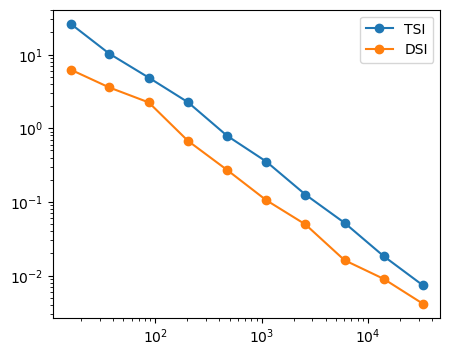

In [28]:
from jax.scipy.special import logsumexp
batch_size = 2**12
seed_samp, seed_time, seed_noise, seed_si = jr.split(seed, 4)
x1 = stoc.base.sample(batch_size, seed_samp)
t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
t = jr.uniform(seed_time, (batch_size,), minval=1/2, maxval=1-stoc.eps)
# t = 0.5 * jnp.ones((batch_size,))
z = jr.normal(seed_noise, jnp.shape(x1))

@partial(jit, static_argnames=['imp_size'])
def loss_si(t, x1, z, seed_si, imp_size):
    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)
    xt = alphat * x1 + betat * z # (batch_size, dim)

    def score_si(seed, xt, alphat, betat):
        z1prop = jr.normal(seed, (imp_size, xt.shape[-1]))
        x1prop = z1prop * betat + xt # (imp_size, dim)

        ##### Denoising Score Identity #####
        imp_weight = vmap(lambda x: stoc.target.log_prob(x / alphat))(x1prop) # (imp_size,)
        imp_weight = jnp.exp(imp_weight - imp_weight.max(0))
        imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, 1)
        score_dsi = (z1prop * imp_weight).mean(0) / betat

        ##### Target Score Identity #####
        lse = lambda x: logsumexp(vmap(lambda zz: stoc.target.log_prob((zz * betat + x) / alphat))(z1prop), axis=0)
        score_tsi = grad(lse)(xt)

        # score_tsi = jnp.clip(score_tsi, a_max=jnp.quantile(score_tsi, 0.99)) # Clip too large scores
        # score_dsi = jnp.clip(score_dsi, a_max=jnp.quantile(score_dsi, 0.99)) # Clip too large scores
        # score_tsi = jnp.clip(score_tsi, max=jnp.quantile(score_tsi, 0.99)) # Clip too large scores
        # score_dsi = jnp.clip(score_dsi, max=jnp.quantile(score_dsi, 0.99)) # Clip too large scores
        return score_tsi, score_dsi

    score_tsi, score_dsi = vmap(score_si)(jr.split(seed_si, x1.shape[0]), xt, alphat, betat)

    score_marg = vmap(stoc.score_marg)(t, xt)
    error_tsi = ((score_marg - score_tsi)**2)
    error_dsi = ((score_dsi - score_marg)**2)
    return error_tsi.mean(), error_dsi.mean()


imp_sizes = np.logspace(4, 15, 10, base=2, dtype=int)
errors_tsi = []
errors_dsi = []
for imp_size in imp_sizes:
    print(f'Imp size: {imp_size}')
    error_tsi, error_dsi = loss_si(t, x1, z, seed_si, imp_size=imp_size)
    errors_tsi.append(error_tsi)
    errors_dsi.append(error_dsi)

plt.figure(figsize=(5,4))
plt.plot(imp_sizes, errors_tsi, '-o', label='TSI')
plt.plot(imp_sizes, errors_dsi, '-o', label='DSI')
plt.xscale('log'), plt.yscale('log')
plt.legend();

In [ ]:
# @title Define the score identity loss
from jax.scipy.special import logsumexp
def loss_si(params, t, x1, z, seed_si):
    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)
    xt = alphat * x1 + betat * z # (batch_size, dim)
    score_est = vmap(partial(stoc.scorenn.apply, params))(t, xt)

    def score_si(seed, xt, alphat, betat):
        imp_size = 2**13
        z1prop = jr.normal(seed, (imp_size, xt.shape[-1]))
        x1prop = z1prop * betat + xt # (imp_size, dim)

        ##### Denoising Score Identity #####
        imp_weight = vmap(lambda x: stoc.target.log_prob(x / alphat))(x1prop) # (imp_size,)
        imp_weight = jnp.exp(imp_weight - imp_weight.max(0))
        imp_weight = (imp_weight / imp_weight.mean(0))[...,None] # (imp_size, 1)
        score_dsi = (z1prop * imp_weight).mean(0) / betat

        ##### Target Score Identity #####
        lse = lambda x: logsumexp(vmap(lambda zz: stoc.target.log_prob((zz * betat + x) / alphat))(z1prop), axis=0)
        score_tsi = grad(lse)(xt)
        # # # Equivalent to 
        # score_tsi = (vmap(grad(lambda x: stoc.target.log_prob(x / alphat)))(x1prop) * imp_weight).mean(0)

        # score_tsi = jnp.clip(score_tsi, a_max=jnp.quantile(score_tsi, 0.99)) # Clip too large scores
        # score_dsi = jnp.clip(score_dsi, a_max=jnp.quantile(score_dsi, 0.99)) # Clip too large scores
        # score_tsi = jnp.clip(score_tsi, max=jnp.quantile(score_tsi, 0.99)) # Clip too large scores
        # score_dsi = jnp.clip(score_dsi, max=jnp.quantile(score_dsi, 0.99)) # Clip too large scores
        return score_tsi, score_dsi

    score_tsi, score_dsi = vmap(score_si)(jr.split(seed_si, x1.shape[0]), xt, alphat, betat)

    score_marg = vmap(stoc.score_marg)(t, xt)
    # score_tsi = score_marg
    error_tsi = ((score_marg - score_tsi)**2)
    debug.print("diff tsi mean: {mean}, std {std}", mean=error_tsi.mean(), std=error_tsi.std())
    error_dsi = ((score_dsi - score_marg)**2)
    debug.print("diff dsi mean: {mean}, std {std}", mean=error_dsi.mean(), std=error_dsi.std())
    # debug.print("dim: {mean}, std {std}", mean=(xt.shape, score_est.shape), std=(alphat.shape, betat.shape))

    error_tsi = alphat**2 * (score_est - score_tsi)**2
    error_dsi = betat**2 * (score_est - score_dsi)**2
    # return (error_tsi + error_dsi).mean()
    return error_tsi.mean()
    # return error_dsi.mean()


# Define the training step
@jit
def train_step(params, opt_state, seed):
    # Sample true x1 or proposal x1
    seed_samp, seed_time, seed_noise, seed_si = jr.split(seed, 4)
    if off_policy:
        # # Sample from proposal and compute importance weights
        # # Current SDE proposal
        # x1 = stoc.sample_sde(params, jr.split(seed_samp, batch_size)) # (batch_size, dim)

        # # Current ODE proposal
        # x1, logprop = stoc.sample_ode(params, jr.split(seed_samp, batch_size))

        # Base proposal
        x1 = stoc.base.sample(batch_size, seed_samp)
    else:
        # Sample from target directly
        x1 = stoc.target.sample(batch_size, seed_samp) # (batch_size, dim)

    # Sample t and xt
    t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
    # t = jr.uniform(seed_time, (batch_size,), minval=1/2, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    loss, grads = value_and_grad(loss_si)(params, t, x1, z, seed_si)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, (loss, 1.)

diff tsi mean: 130442.96627367198, std 4034360.7018738766
diff dsi mean: 9.14730178897794, std 22.463412800789158
Epoch 0, Loss: 12.61648, n/ESS: 1.00000
diff tsi mean: 91016.38473310588, std 1397083.1452484233
diff dsi mean: 8.630596683646294, std 20.678543030624116
diff tsi mean: 97923.91616640877, std 2238604.10304231
diff dsi mean: 9.03070361719985, std 22.595999127598688
diff tsi mean: 179352.91643574124, std 6534491.9529412
diff dsi mean: 9.009317013513613, std 22.729858195458014
diff tsi mean: 84431.17174208973, std 1303338.1654192498
diff dsi mean: 9.344568155392587, std 22.668793547093884
diff tsi mean: 125648.87366498512, std 2761670.935130744
diff dsi mean: 8.69713331635771, std 20.67893914618854
diff tsi mean: 135918.773966134, std 4179586.491269597
diff dsi mean: 8.427639708567284, std 20.017254354974316
diff tsi mean: 102771.29973965799, std 2422580.3318260526
diff dsi mean: 9.245608611892347, std 23.83228438414887
diff tsi mean: 244536.37548806454, std 9781790.587884447


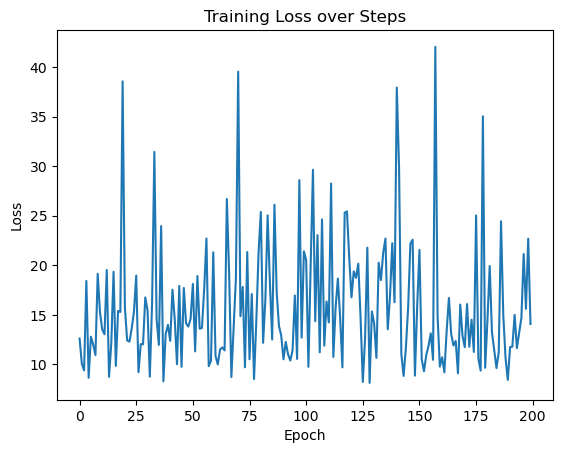

In [139]:
for epoch in range(200):
    seed, seed_train = jr.split(seed, 2)
    params, opt_state, (loss, eval_per_ess) = train_step(params, opt_state, seed)
    losses.append(loss)
    eval_per_esss.append(eval_per_ess)

    if epoch % 10 == 0:
        # print(f"Epoch {epoch}, Loss: {loss}, lr scale: {optax.tree.get(optim_state, 'scale')}")
        # print(f"Epoch {epoch}, Loss: {loss:.5f}, n/ESS: {eval_per_ess:.5f}, lr scale: {opt_state[1].scale}")
        print(f"Epoch {epoch}, Loss: {loss:.5f}, n/ESS: {eval_per_ess:.5f}")

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

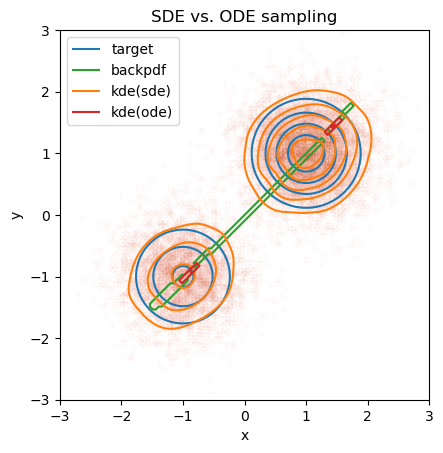

In [140]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) #

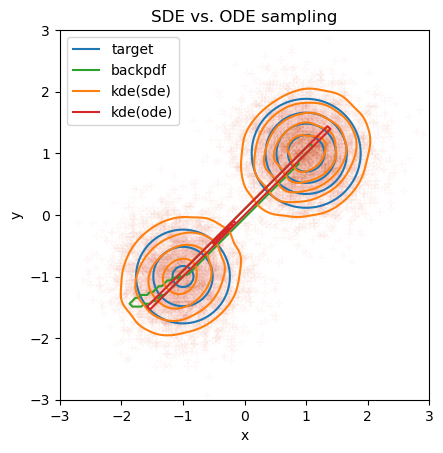

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) #

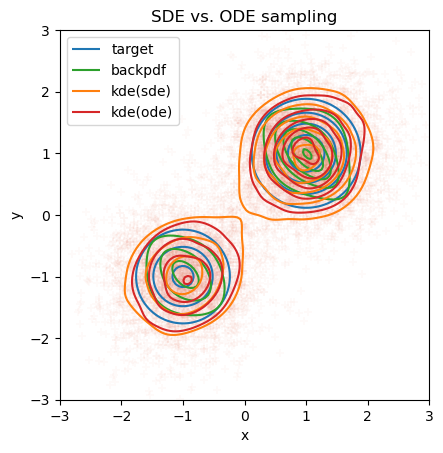

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) #

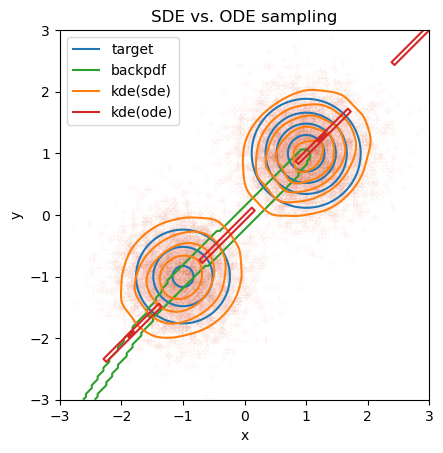

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSI+TSI

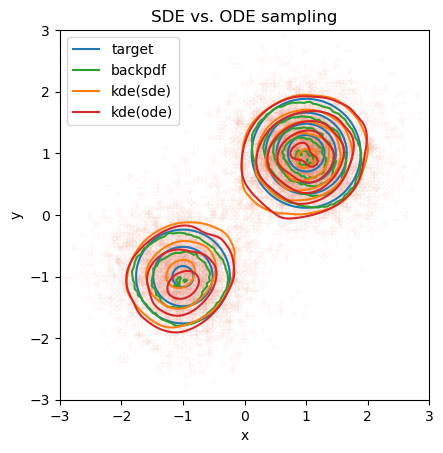

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM on

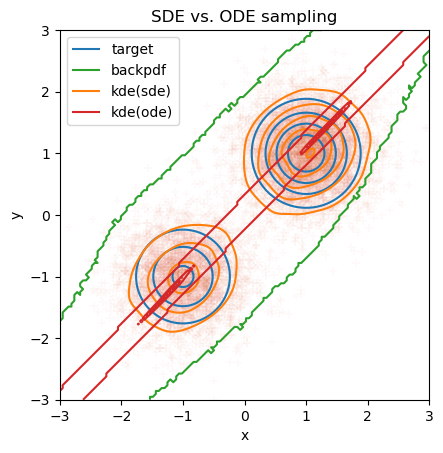

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSM on

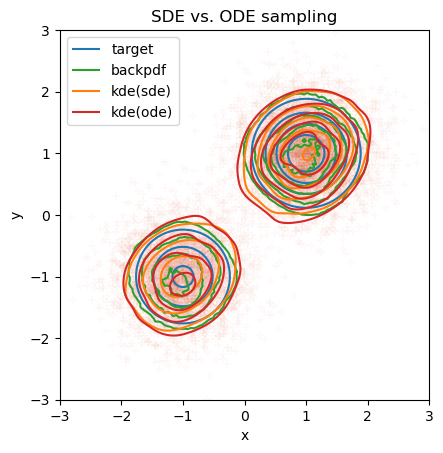

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM+TSM on

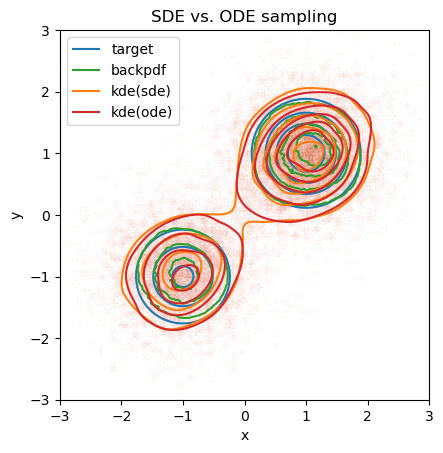

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM off

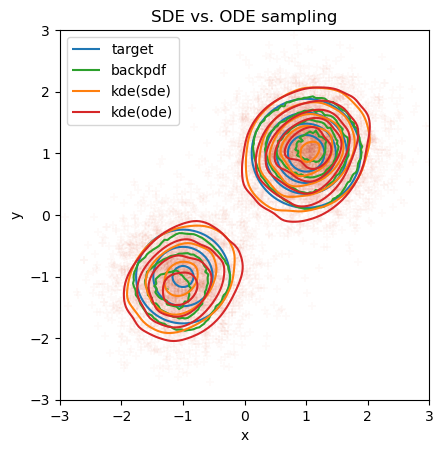

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM+TSM off

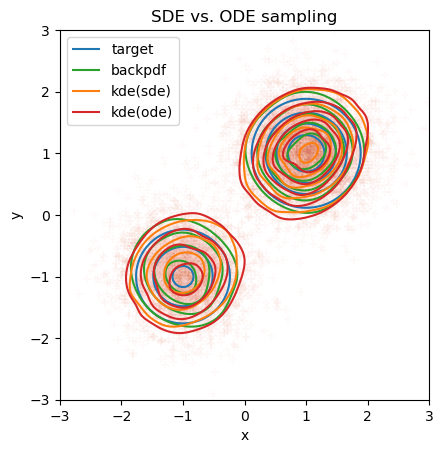

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP DSM+TSM off, unormalized IS

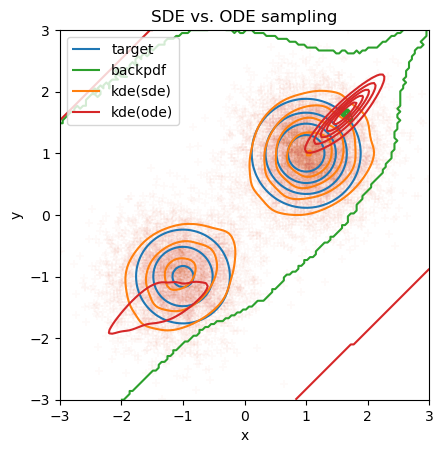

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # OT DSM on

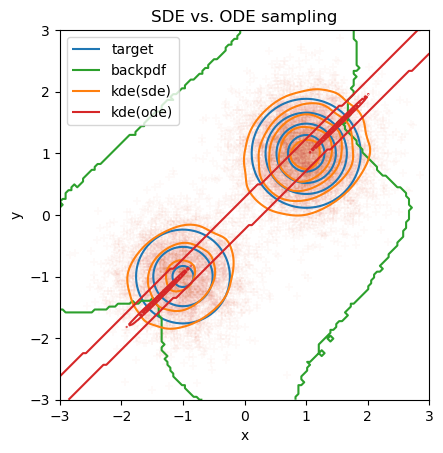

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # OT DSM+TSM on

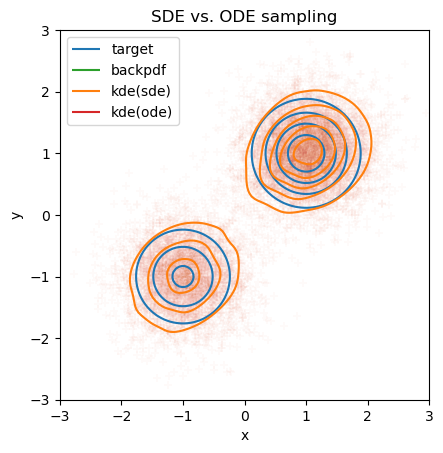

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # PB DSM+TSM on

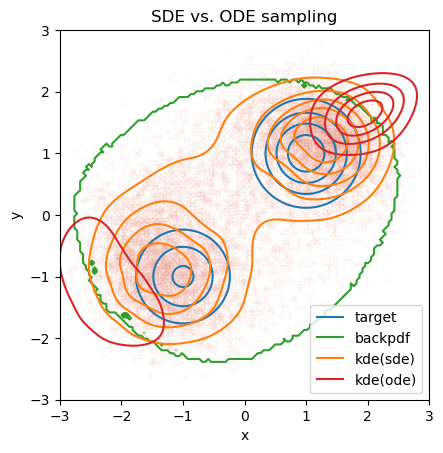

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params) # VP TSI on

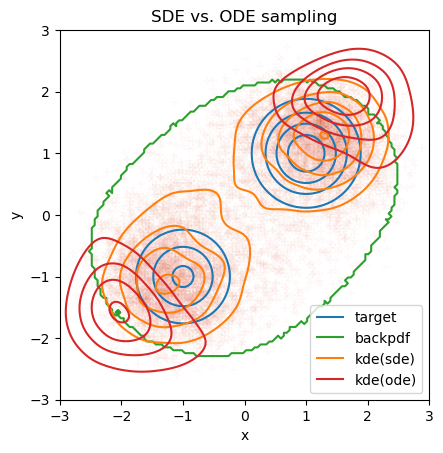

In [ ]:
x1_sde, x1_ode, logp1f, logp1b = plot_results(params)  # VP TSI off

## 4. Dependency with dimension
Where we look at the variances of objectives and losses and their dependency to dimension.
* When doing Importance Sampling (IS), we can define the (unormalized) IS weight $\tilde w := \frac{\tilde \pp}{\qq}$ where $\pp \propto \tilde \pp$ is our target known up to a constant, and $\qq$ is the proposal. The Self-Normalized Importance Sampling (SNIS) weight for a set of samples $(x_i)_{i=1}^n$ can then be defined as $w_n(x_i) := \frac{n\tilde w(x_i)}{\sum_{j=1}^n \bar w(x_j)}$, and the associated Effective Sample Size is $n_\mathrm{eff} := n/\EE_x[w_n(x)^2]$.
* Therefore, $n / n_\mathrm{eff} = \EE_x[w_n(x)^2] \xrightarrow[n \to +\infty]{} 1 + \chi^2(\pp \mid\mid \qq)$, the $\chi^2$ divergence between target and proposal.
* Recall the regression objective $s_t(\bs y_1,\bs y_t) = \lambda_t \nabla\log\pp_1(\bs y_1) + (1-\lambda_t)\nabla\log \pp_{t\mid 1}(\bs y_t \mid \bs y_1)$ (mixture TSM+DSM). We want to look at $$\EE_{t, \bs y_1, \bs y_t}[w(\bs y_1)\norm{\nabla \log \pp_t(\bs y_t) - s_t(\bs y_1,\bs y_t)}^2] = \Var_{t, \bs y_1, \bs y_t}[s_t(\bs y_1,\bs y_t)]$$ and $$\Var_{t, \bs y_1, \bs y_t}[w(\bs y_1)\norm{\nabla \log \pp_t(\bs y_t) - s_t(\bs y_1,\bs y_t)}^2]$$



In [ ]:
@partial(jit, static_argnames=['dim', 'batch_size', 'off_policy'])
def loss_sm(seed, batch_size, dim, off_policy=True):
    stoc = StochInterp(scheduling='VP', dim=dim, hutch_div=None, snapshots=None, pid=False)
    seed_samp, seed_time, seed_noise = jr.split(seed, 3)

    if off_policy:
        # Base proposal
        x1 = stoc.base.sample(batch_size, seed_samp)
        logprop = vmap(stoc.base.log_prob)(x1)
        
        logp1, score1 = vmap(value_and_grad(stoc.target.log_prob))(x1)
        # logp1, score1 = vmap(value_and_grad(tfd.MultivariateNormalDiag(loc=jnp.zeros(dim), scale_diag=0.9*jnp.ones(dim)).log_prob))(x1)
        imp_weight = logp1 - logprop # (batch_size,)
        
        # imp_weight = jnp.clip(imp_weight, a_max=jnp.quantile(imp_weight, 0.999)) # Clip too large weights
        # imp_weight = jnp.clip(imp_weight, max=jnp.quantile(imp_weight, 0.999)) # Clip too large weights
        imp_weight = jnp.exp(imp_weight - imp_weight.max())
        imp_weight = (imp_weight / imp_weight.mean())[:,None] # (batch_size, 1)
    else:
        x1 = stoc.target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(stoc.score_target)(x1)
        imp_weight = jnp.ones((batch_size, 1))

    t = jr.uniform(seed_time, (batch_size,), minval=stoc.eps, maxval=1-stoc.eps)
    z = jr.normal(seed_noise, jnp.shape(x1))

    alphat = stoc.alpha(t)[:,None] # (batch_size, 1)
    betat = stoc.beta(t)[:,None] # (batch_size, 1)

    xt = alphat * x1 + betat * z
    score_marg = vmap(stoc.score_marg)(t, xt)
    # score_marg = - xt / (0.9**2 * alphat**2 + betat**2)

    error_dsm = (score_marg * betat + z)**2
    error_tsm = (score_marg * alphat - score1)**2
    error_dsm *= imp_weight
    error_tsm *= imp_weight
    eval_per_ess = (imp_weight**2).mean()

    dsm_mean, dsm_std = error_dsm.mean(), error_dsm.mean(-1).std()
    tsm_mean, tsm_std = error_tsm.mean(), error_tsm.mean(-1).std()
    return dsm_mean, dsm_std, tsm_mean, tsm_std, eval_per_ess


dsm_means = []
dsm_stds = []
tsm_means = []
tsm_stds = []
eval_per_esss = []
dims = np.logspace(0, 3, 10, dtype=int)
batch_size = 2**18
seed = jr.key(0)
off_policy = True

for dim in dims:
    print(f"Dim {dim}")
    seed, seed_loss = jr.split(seed, 2)
    dsm_mean, dsm_std, tsm_mean, tsm_std, eval_per_ess = loss_sm(seed_loss, batch_size, dim, off_policy=off_policy)
    dsm_means.append(dsm_mean)
    dsm_stds.append(dsm_std)
    tsm_means.append(tsm_mean)
    tsm_stds.append(tsm_std)
    eval_per_esss.append(eval_per_ess)

Dim 1
Dim 2
Dim 4
Dim 10
Dim 21
Dim 46
Dim 100
Dim 215
Dim 464
Dim 1000


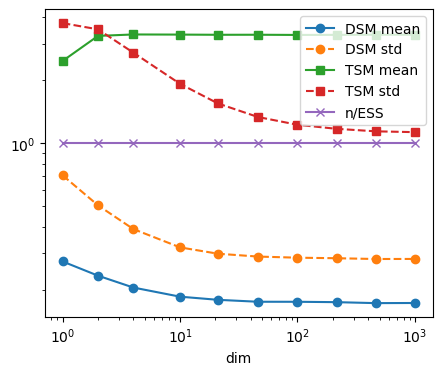

In [ ]:
plt.figure(figsize=(5,4)) # on-policy
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

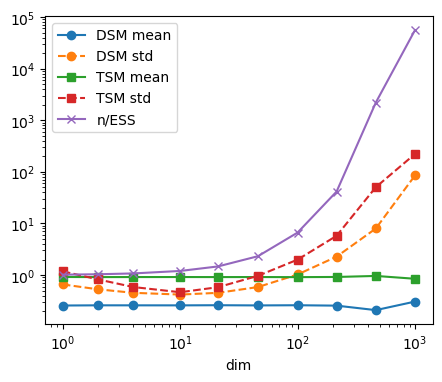

In [16]:
plt.figure(figsize=(5,4)) # off-policy Gaussian, no weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

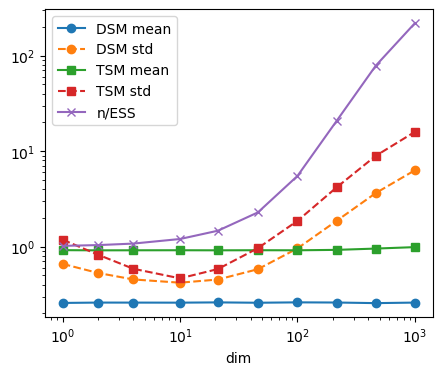

In [12]:
plt.figure(figsize=(5,4)) # off-policy Gaussian, weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

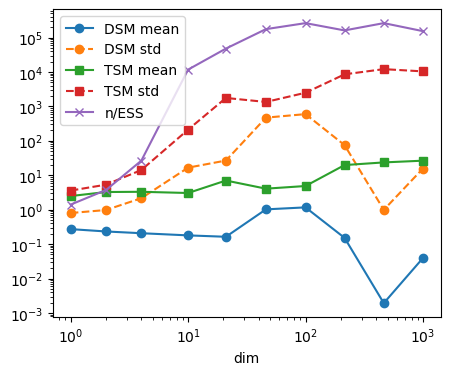

In [10]:
plt.figure(figsize=(5,4)) # off-policy, no weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();

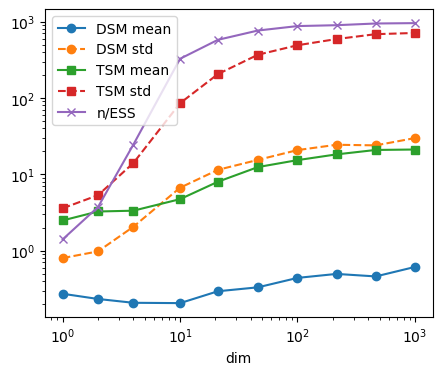

In [12]:
plt.figure(figsize=(5,4)) # off-policy, weight clipping
plt.plot(dims, dsm_means, 'o-', label='DSM mean')
plt.plot(dims, dsm_stds, 'o--', label='DSM std')
plt.plot(dims, tsm_means, 's-', label='TSM mean')
plt.plot(dims, tsm_stds, 's--', label='TSM std')
plt.plot(dims, eval_per_esss, 'x-', label='n/ESS')
plt.xscale('log'), plt.yscale('log')
plt.xlabel('dim')
plt.legend();